# BRCA Cluster Analysis

In this Notebook, you will find our Cluster-Analysis of the HER2 positive Patients among the Breast Cancer (BRCA) Cohort from The Cancer Genome Atlas (TCGA).
These analyses are featured in Figure 7 (Fig. 7) and supplementary Figure 1 (Fig. S1) of our manuscript. 

In [ ]:
# import the necessary libraries for the analysis

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering 
import scipy.cluster.hierarchy as shc 
import lifelines
import openpyxl


%matplotlib inline

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

The .tsv containing gene expression and phenotypic data was downloaded from [UCSC Xenabrowser](https://xenabrowser.net/).

In [2]:
# read the file containing gene expression counts and phenotypic information

df = pd.read_csv("BRCA_IL22.tsv", sep= "\t", index_col= 0)
df

Sample Filtering and Scaling

In this following section of the Notebook we first filter for primary tumor samples, to make sure we do not include cell line samples etc. Next, we create a dataframe, containing only the gene expression counts for the genes we selected as features for our "IL-22 Signature":

    IL22RA1
    IL22RA2
    IL10RB
    PVR

Looking at the density of the gene expression counts, we noticed that PVR and IL10RB have a generally higher gene expression count than IL22RA1 and IL22RA2. This is why we decided to scale the dataset with a z-Score (here StandardScaler).


In [4]:
# filtering out non primary tumor samples (e.g. Cellines, healthy tissue, metastases)
df_clean = df.loc[df["sample_type"]== "Primary Tumor"] 

# filtering for HER2 positive samples
df_her2 =df_clean.loc[df_clean["HER2_Final_Status_nature2012"]=="Positive"].copy()

#create a dataframe with only the gene expression data for further processing
X = df_her2.loc[:, df_her2.dtypes==np.float64].copy() 

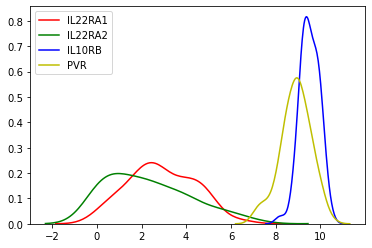

In [9]:
#plotting the densities of the log2+1 gene expression counts

fig = sns.kdeplot(X["IL22RA1"], color="r")
fig = sns.kdeplot(X["IL22RA2"], color="g")
fig = sns.kdeplot(X["IL10RB"], color="b")
fig = sns.kdeplot(X["PVR"], color="y")
plt.show()

In [10]:
# Scaling the gene expression data 

scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X)

X_scaled =  pd.DataFrame(X_scaled, index = X.index, columns = X.columns)

#density plots of the scaled dataset
fig = sns.kdeplot(X_scaled["IL22RA1"], color="r")
fig = sns.kdeplot(X_scaled["IL22RA2"], color="g")
fig = sns.kdeplot(X_scaled["IL10RB"], color="b")
fig = sns.kdeplot(X_scaled["PVR"], color="y")
plt.show()

,IL22RA1,IL22RA2,IL10RB,PVR
count,1.100000e+02,1.100000e+02,1.100000e+02,1.100000e+02
mean,5.046468e-16,3.229740e-17,-3.157071e-15,2.926952e-16
std,1.004577e+00,1.004577e+00,1.004577e+00,1.004577e+00
min,-1.962366e+00,-1.245338e+00,-3.264063e+00,-2.740162e+00
25%,-6.919686e-01,-8.382486e-01,-7.054421e-01,-5.880092e-01
50%,-1.208754e-01,-1.224447e-01,-3.564290e-02,7.018932e-02
75%,8.129459e-01,7.082091e-01,7.714622e-01,6.880008e-01
max,2.508564e+00,2.627885e+00,2.313558e+00,2.350780e+00


## Dimensionality Reduction and Clustering

We chose t-distributed nearest neighbour embedding (t-SNE) as our method of dimensionality reduction. 

Following this, we used an agglomerative clustering algorithm to visualize the clustering of the cohort. By examining the dendrogram, we chose to fit three clusters to the dataset (Fig. 7A). A two dimensional visualisation of the dimensionality reduced data with the fit clusters can be seen in the dotplot (Fig. 7B).
We used the [agglomerative clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) method of [sklearn](https://scikit-learn.org/stable/index.html) and the [hierarchical clustering](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html) from [scipy](https://scipy.org/).

In [168]:
#TSNE dimensionality reduction

tsne = TSNE(n_components=2, perplexity = 20)
tsne_results = tsne.fit_transform(X_scaled).copy()

df_TSNE = pd.DataFrame(tsne_results)
df_TSNE.columns = ['D1', 'D2'] 


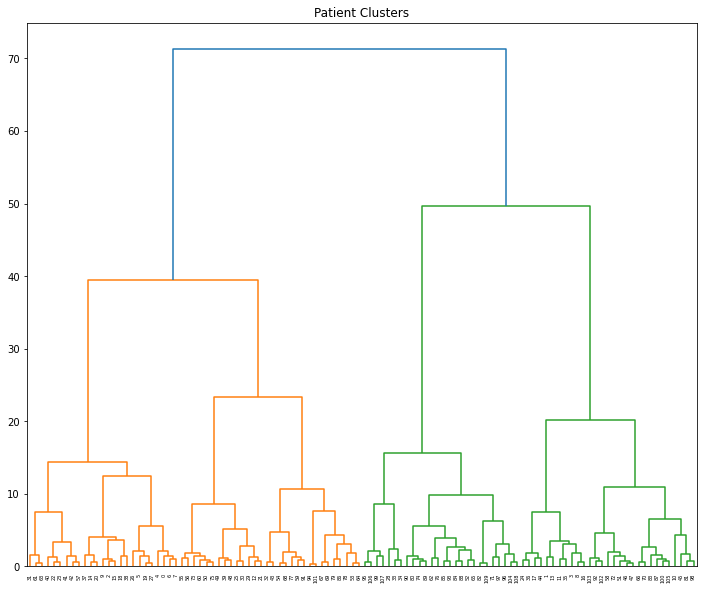

In [190]:
#dendrogram visulization of linkage of tsne reduced data

plt.figure(figsize =(12, 10)) 
plt.title('Patient Clusters') 

Dendrogram = shc.dendrogram((shc.linkage(df_TSNE, method ='ward')))
plt.savefig(fname = "BRCA_HER2+_Main_Dendrogram_plt.svg", format = "svg")

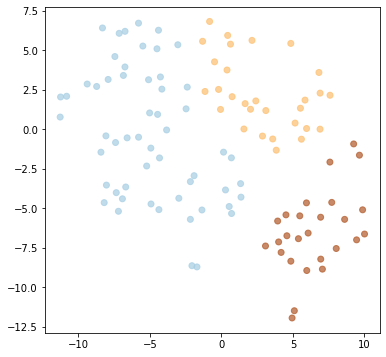

In [191]:
# Visualizing the clustering of tsne reduced data, n clusters was determined after examination of the dendrogram
ac = AgglomerativeClustering(n_clusters = 3) 
fig = plt.figure(figsize = (6,6))
plt.scatter(df_TSNE["D1"], df_TSNE["D2"], 
           c = ac.fit_predict(df_TSNE), cmap ='Paired', alpha = 0.7)
plt.savefig(fname = "BRCA_HER2+_Main_TSNE_2D_plt.svg", format = "svg")

## General Properties of the Clusters

By joining the cluster labels with the scaled high dimensional gene expression data, we were able to evaluate, whether the clustering resulted in distinct gene expression patterns. We plotted a heatmap, displaying the mean count of each gene per cluster (Fig. C). We then proceeded to analyze the proportion of each cluster within the LUAD cohort, which is visualized in the pie chart below (Fig. 7D).

In [192]:
# Reassigning the patient codes to the TSNE transformed data, 
# fitting the cluster algorithm to the indexed data, and joining the predicted clusters with the scaled gene expression dataset

df_TSNE_ind = df_TSNE.set_index(X.index)
df_TSNE_ind["Cluster"] = ac.fit_predict(df_TSNE_ind)
df_clusters_tsne = X_scaled.join(df_TSNE_ind["Cluster"])

#Plotting the mean expression of each gene per cluster
cluster_means_tsne = df_clusters_tsne.groupby("Cluster").mean()
sns.heatmap(cluster_means_tsne, cmap= "coolwarm")
plt.savefig(fname = "BRCA_HER2+_Main_Cluster_Means.svg", format = "svg")


In [194]:
df_clusters_tsne_d = df_clusters_tsne.drop("Cluster", axis = 1).copy()
df_clusters_tsne_d

,IL22RA1,IL22RA2,IL10RB,PVR
sample,,,,
TCGA-BH-A0C7-01,2.508564,-0.089387,-0.654097,0.061457
TCGA-C8-A138-01,2.307502,-0.053077,0.984344,-0.226710
TCGA-E2-A14Y-01,1.906055,1.034591,-0.377177,1.410600
TCGA-BH-A0EE-01,1.640462,1.667573,1.782795,-1.508905
TCGA-A8-A08G-01,1.512081,-0.755752,0.333583,0.026528
...,...,...,...,...
TCGA-AQ-A04L-01,-1.623277,1.619883,-0.051797,-0.440651
TCGA-A8-A09G-01,-1.700645,0.255285,-1.904850,-1.980450
TCGA-BH-A1F2-01,-1.962366,0.009246,-0.040258,-2.513122


Infiltrating Ductal Carcinoma       601
Infiltrating Lobular Carcinoma       68
Other, specify                       33
Mixed Histology (please specify)     21
Mucinous Carcinoma                    5
Medullary Carcinoma                   3
Name: histological_type, dtype: int64

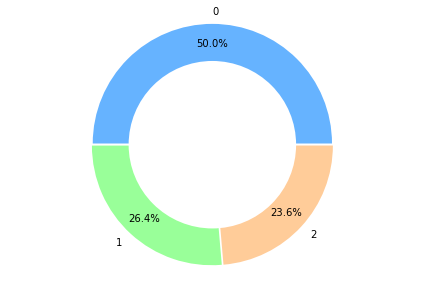

In [201]:
#Proportions of the clusters within the cohort
data = df_clusters_tsne["Cluster"].value_counts(normalize = True)*100
labels = data.index
explode = (0.01, 0.01, 0.01)
colors = ["#66b3ff", "#99ff99", "#ffcc99"]

fig1, ax1 = plt.subplots()
ax1.pie(data, labels = labels, explode = explode, colors = colors, pctdistance = 0.83, autopct="%1.1f%%")

centre_circle = plt.Circle((0,0), 0.7, fc ="white")
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis("equal")
plt.tight_layout()
plt.savefig(fname = "BRCA_HER2+_Main_cluster_props.svg", format = "svg")
plt.show()


In [202]:
# create a dataframe containing genetic, phenotypic and cluster information for further analyses

df_pc = df_clean.join(df_clusters_tsne ["Cluster"])
df_pc = df_pc.dropna()
df_pc

## Survival Analysis

We used the Kaplan Meier model to asess whether the gene expression patterns correlate with different survival outcomes of LUAD patients. The overview plot was used for Fig. 7E. We used the [Lifelines Library](https://lifelines.readthedocs.io/en/latest/) for our survival analysis.

In [239]:
from lifelines import KaplanMeierFitter
T = df_pc["OS_Time_nature2012"]
E = df_pc["OS_event_nature2012"]
kmf = KaplanMeierFitter()
clusters = df_pc["Cluster"]
cl0 = (clusters == 0)
cl1 = (clusters == 1) 
cl2 = (clusters == 2)

#plotting kaplan meier plots for each cluster seperately for enhanced visibility

fig, (ax0, ax1, ax2) = plt.subplots(nrows = 1, ncols = 3, sharex = True, figsize = (20,20))

kmf= KaplanMeierFitter()
ax0 = kmf.fit(T[cl0], E[cl0], label="Cluster 0").plot(ax=ax0, figsize = (18, 6), at_risk_counts = True, color = "#66b3ff")
ax1 = kmf.fit(T[cl1], E[cl1], label="Cluster 1").plot(ax=ax1, figsize = (18, 6), at_risk_counts = True, color = "#99ff99")
ax2 = kmf.fit(T[cl2], E[cl2], label="Cluster 2").plot(ax=ax2, figsize = (18, 6), at_risk_counts = True, color = "#ffcc99")

plt.savefig(fname = "BRCA_Main_SurvivalbyCluster.svg", format = "svg")
plt.tight_layout()

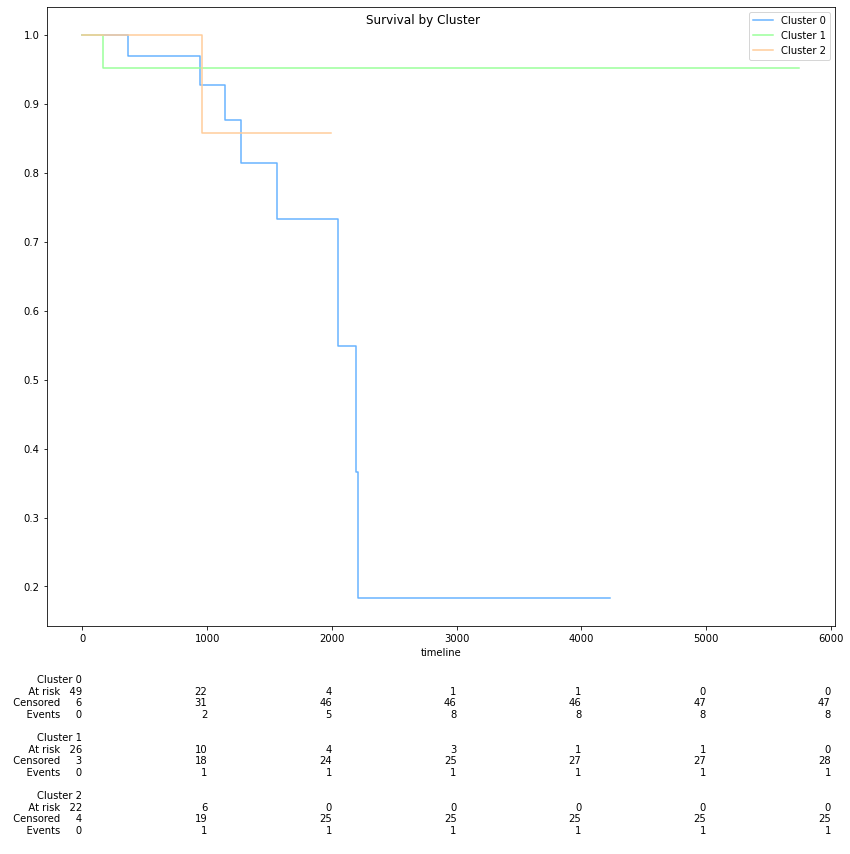

In [241]:
#plotting summary of all kaplan meier plots without confidence intervals to avoid overcrowding of the plot

fig, (ax) = plt.subplots(nrows = 1, ncols = 1, sharex = True, figsize = (12, 12))

kmf0= KaplanMeierFitter()
ax = kmf0.fit(T[cl0], E[cl0], label="Cluster 0").plot(ax=ax, figsize = (12, 12), ci_show = False, color = "#66b3ff")

kmf1= KaplanMeierFitter()
ax = kmf1.fit(T[cl1], E[cl1], label="Cluster 1").plot(ax=ax, figsize = (12, 12), ci_show = False, color = "#99ff99")

kmf2= KaplanMeierFitter()
ax = kmf2.fit(T[cl2], E[cl2], label="Cluster 2").plot(ax=ax, figsize = (12, 12), ci_show = False, color = "#ffcc99")


from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf0, kmf1, kmf2, ax=ax)

fig.suptitle("Survival by Cluster")
plt.savefig(fname = "BRCA_HER2+_Main_SurvivalbyCluster_summary.svg", format = "svg")
plt.tight_layout()




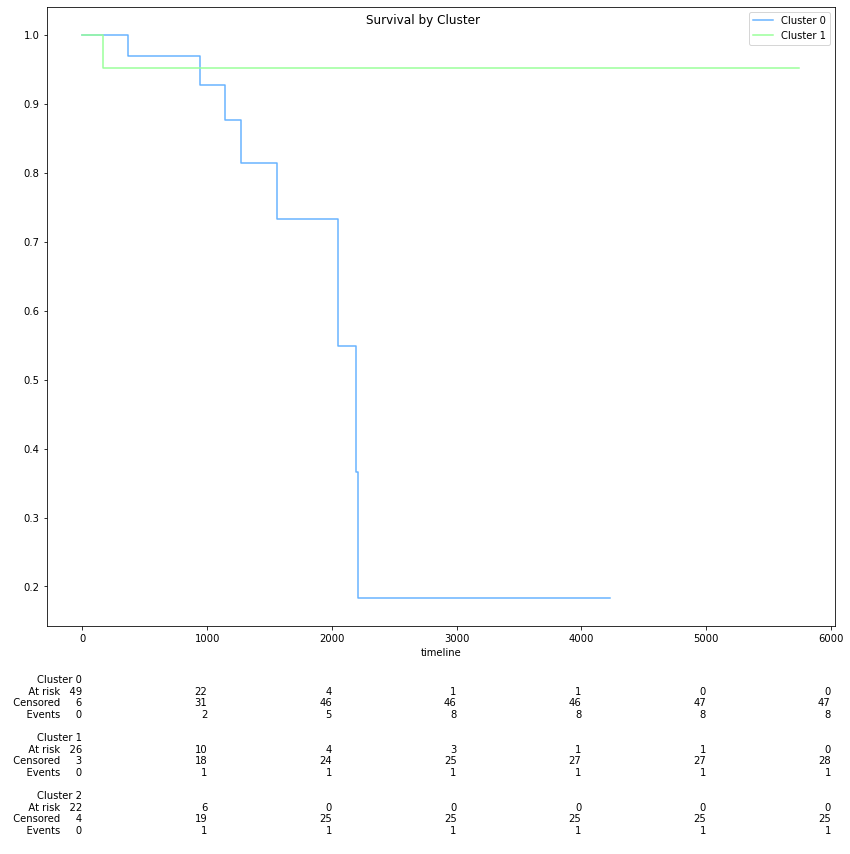

In [242]:
#plotting cluster 0 and 1 survival times w/o confidence intervals for visibility

fig, (ax) = plt.subplots(nrows = 1, ncols = 1, sharex = True, figsize = (12, 12))

kmf0= KaplanMeierFitter()
ax = kmf0.fit(T[cl0], E[cl0], label="Cluster 0").plot(ax=ax, figsize = (12, 12), ci_show = False, color = "#66b3ff")

kmf1= KaplanMeierFitter()
ax = kmf1.fit(T[cl1], E[cl1], label="Cluster 1").plot(ax=ax, figsize = (12, 12), ci_show = False, color = "#99ff99")

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf0, kmf1, kmf2, ax=ax)

fig.suptitle("Survival by Cluster")
plt.savefig(fname = "BRCA_HER2+_Main_SurvivalbyCluster_1_2_summary.svg", format = "svg")
plt.tight_layout()



### RMST

We used the restricted mean survival time ([RMST](https://lifelines.readthedocs.io/en/latest/Examples.html)) to assess the survival differences (delta RMST) between the clusters. A selection of this analysis can be found in Fig. 7F. we decided to set the time limit to five years.  "RMST is the average time free from an event up until a milestone time point, 
a numeric expression of the area under the Kaplan-Meier survival curve [...]. The comparison of RMSTs between treatment groups, 
the RMST difference (ΔRMST), is the mean absolute difference of event-free time associated with a therapy." [(Perego et. al. 2020)](https://doi.org/10.1016/j.jchf.2020.07.005), or in this case the gene expression cluster.

In [243]:
#Calculating the RMST (Restricted mean survival time)

from lifelines.utils import restricted_mean_survival_time
time_limit = 1825 #5 years

kmf_0 = kmf0.fit(T[cl0], E[cl0], label="Cluster 0")
rmst_0 = restricted_mean_survival_time(kmf_0, t=time_limit)

kmf_1 = kmf1.fit(T[cl1], E[cl1], label="Cluster 1")
rmst_1 = restricted_mean_survival_time(kmf_1, t=time_limit)

kmf_2 = kmf2.fit(T[cl2], E[cl2], label="Cluster 2")
rmst_2 = restricted_mean_survival_time(kmf_2, t=time_limit)





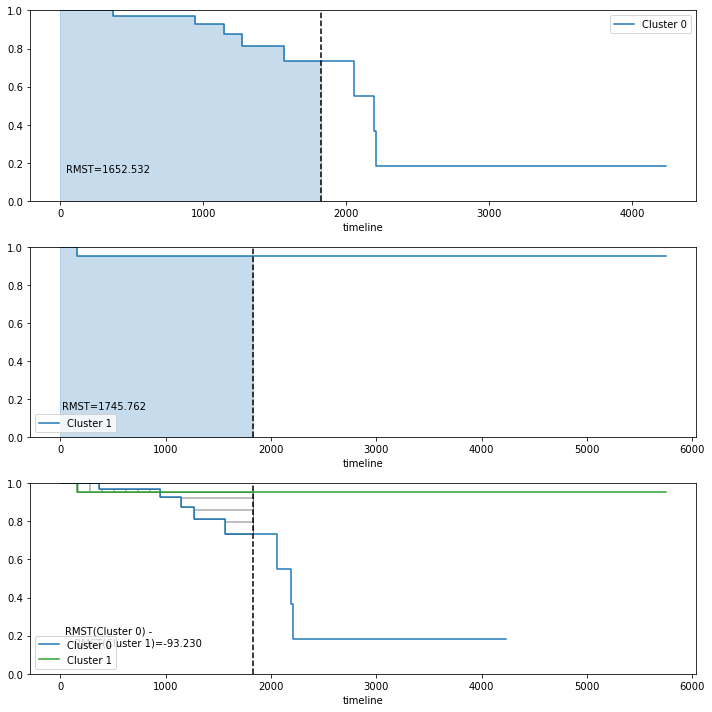

In [244]:
#Plotting RMSTs of Cluster 1 vs. Cluster 2 

from lifelines.plotting import rmst_plot

ax = plt.subplot(311)
rmst_plot(kmf_0, t=time_limit, ax=ax, figsize = (10,10))


ax = plt.subplot(312)
rmst_plot(kmf_1, t=time_limit, ax=ax, figsize = (10,10))


ax = plt.subplot(313)
rmst_plot(kmf_0, model2=kmf_1, t=time_limit, ax=ax, figsize = (10,10))



plt.tight_layout()
plt.savefig(fname = "BRCA_HER2+_Main_Cl1vs2_RMST.svg", format = "svg")


In [ ]:
#Plotting the delta of RMSTs of Cluster 0 vs. Cluster 2

from lifelines.plotting import rmst_plot

ax = plt.subplot(311)
rmst_plot(kmf_0, t=time_limit, ax=ax, figsize = (10,10))


ax = plt.subplot(312)
rmst_plot(kmf_2, t=time_limit, ax=ax, figsize = (10,10))


ax = plt.subplot(313)
rmst_plot(kmf_0, model2=kmf_2, t=time_limit, ax=ax, figsize = (10,10))

plt.savefig(fname = "BRCA_HER2+_Main_Cl0vs2_RMST.svg", format = "svg")

plt.tight_layout()


In [ ]:
#Plotting the delta of RMSTs of Cluster 0  vs. Cluster 1 

from lifelines.plotting import rmst_plot

ax = plt.subplot(311)
rmst_plot(kmf_0, t=time_limit, ax=ax, figsize = (10,10))


ax = plt.subplot(312)
rmst_plot(kmf_1, t=time_limit, ax=ax, figsize = (10,10))


ax = plt.subplot(313)
rmst_plot(kmf_0, model2=kmf_1, t=time_limit, ax=ax, figsize = (10,10))

plt.savefig(fname = "BRCA_HER2+_Main_Cl0vs1_RMST.svg", format = "svg")

plt.tight_layout()


## Statistical Testing of the Survival Curves

We chose the [log rank test](https://lifelines.readthedocs.io/en/latest/Examples.html) to test whether the survival curves differ significantly from one another. Here, the p-values for Fig. 7E were calculated.

In [245]:
# logrank test of cluster 1 vs cluster 2
from lifelines.statistics import logrank_test

results = logrank_test(T[cl1], T[cl2], E[cl1], E[cl2], alpha=.95)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.05 0.83      0.27

In [246]:
# logrank test of cluster 0 vs cluster 2
from lifelines.statistics import logrank_test

results = logrank_test(T[cl0], T[cl2], E[cl0], E[cl2], alpha=.95)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.08 0.78      0.36

In [247]:
# logrank test of cluster 0 vs cluster 1
from lifelines.statistics import logrank_test

results = logrank_test(T[cl1], T[cl0], E[cl1], E[cl0], alpha=.95)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.15 0.04      4.59

## Cox Proportional Hazards Model

To see the impact of each gene of our IL-22 signature, we applied the [cox proportional hazards model](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html) (CoxPH). In a first step, we create a dataframe containing the scaled gene expression counts, the observation and the survival event information as an appropriate input for the model. 

In [248]:
#create a dataframe as input for the CoxPH model

df_cox = X_scaled.join(df_pc["OS_event_nature2012"])
df_cox_surv =df_cox.join(df_pc["OS_Time_nature2012"])
df_cox_surv

,IL22RA1,IL22RA2,IL10RB,PVR,OS_event_nature2012
sample,,,,,
TCGA-BH-A0C7-01,2.508564,-0.089387,-0.654097,0.061457,0
TCGA-C8-A138-01,2.307502,-0.053077,0.984344,-0.226710,0
TCGA-E2-A14Y-01,1.906055,1.034591,-0.377177,1.410600,0
TCGA-BH-A0EE-01,1.640462,1.667573,1.782795,-1.508905,0
TCGA-A8-A08G-01,1.512081,-0.755752,0.333583,0.026528,0
...,...,...,...,...,...
TCGA-AQ-A04L-01,-1.623277,1.619883,-0.051797,-0.440651,0
TCGA-A8-A09G-01,-1.700645,0.255285,-1.904850,-1.980450,0
TCGA-BH-A1F2-01,-1.962366,0.009246,-0.040258,-2.513122,1


<lifelines.CoxPHFitter: fitted with 110 total observations, 100 right-censored observations>
             duration col = 'OS_Time_nature2012'
                event col = 'OS_event_nature2012'
      baseline estimation = breslow
   number of observations = 110
number of events observed = 10
   partial log-likelihood = -27.78
         time fit was run = 2022-01-18 16:17:43 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
IL22RA1     0.11       1.11       0.30            -0.48             0.70                 0.62                 2.01
IL22RA2     0.15       1.17       0.36            -0.55             0.86                 0.58                 2.36
IL10RB     -0.93       0.40       0.41            -1.72            -0.13                 0.18                 0.88
PVR         0.23       1.25       0.41            -0.57             1.02                 0.57                 2.79

              z    p   -log2(p)
covariate                      
IL22RA1    0.35 0.72       0.47
IL22RA2    0.43 0.67       0.58
IL10RB    -2.27 0.02       5.43
PVR        0.56 0.58       0.79
---
Concordance = 0.72
Partial AIC = 63.55
log-likelihood ratio test = 7.40 on 4 df
-log2(p) of ll-ratio test = 3.10

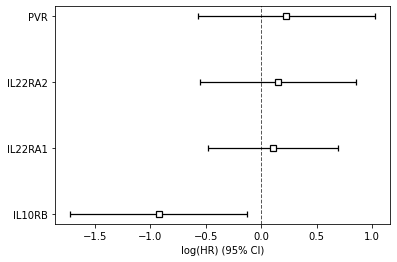

In [250]:
# Using Cox Proportional Hazards model to see the impact of each gene on survival

from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(df_cox_surv, duration_col = "OS_Time_nature2012", event_col='OS_event_nature2012')
cph.print_summary()
cph.plot()
plt.savefig(fname = "BRCA_HER2+_Main_CoxPH_genes.svg", format = "svg")

## Clinical Phenotype

To see the clinical impact of the gene signatures, we analyzed the prevalence of pathological cancer stages among the clusters. In a first step, we summarized stae subtypes (e.g. IIA and IIB) to the main stage (e.g. Stage II). We then created dataframes containing the relative proportion of each stage per cluster as input for the pie charts, which can be found in Fig. 7F.

In [252]:
#summary of substages

df_pc["AJCC_Stage_nature2012"] = df_pc["AJCC_Stage_nature2012"].replace({"Stage IA": "Stage I", "Stage IB": "Stage I", "Stage IIA": "Stage II", "Stage IIB": "Stage II",
                                                              "Stage IIIA": "Stage III", "Stage IIIB": "Stage III", "Stage IIIC": "Stage III"})
df_pc["AJCC_Stage_nature2012"].value_counts()


<ipython-input-252-77cfa92f14f5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pc["AJCC_Stage_nature2012"] = df_pc["AJCC_Stage_nature2012"].replace({"Stage IA": "Stage I", "Stage IB": "Stage I", "Stage IIA": "Stage II", "Stage IIB": "Stage II",


Stage II     70
Stage III    30
Stage I       7
Stage X       2
Stage IV      1
Name: AJCC_Stage_nature2012, dtype: int64

In [253]:
#removal of non essential information for the pie charts
df_stage_cl = df_pc.drop(["IL22RA1", "IL22RA2", "samples", "IL10RB", "PVR", "histological_type", "sample_type", "OS_event_nature2012", "OS_Time_nature2012", "ER_Status_nature2012", "HER2_Final_Status_nature2012", "PR_Status_nature2012"], axis =1)

In [254]:
#calculating the relative proportions of each cancer stage per cluster

df_cl_0 = df_stage_cl.loc[df_stage_cl["Cluster"]==0]
df_cl_1 = df_stage_cl.loc[df_stage_cl["Cluster"]==1]
df_cl_2 = df_stage_cl.loc[df_stage_cl["Cluster"]==2]

data_sc_0 = pd.DataFrame(df_cl_0.groupby("Cluster")["AJCC_Stage_nature2012"].value_counts(normalize = True)*100)
data_sc_1 = pd.DataFrame(df_cl_1.groupby("Cluster")["AJCC_Stage_nature2012"].value_counts(normalize = True)*100)
data_sc_2 = pd.DataFrame(df_cl_2.groupby("Cluster")["AJCC_Stage_nature2012"].value_counts(normalize = True)*100)

data_sc_0.reset_index(level=0, drop=True, inplace = True)
data_sc_1.reset_index(level=0, drop=True, inplace = True)
data_sc_2.reset_index(level=0, drop=True, inplace = True)

data_sc_0.sort_index(inplace = True)
data_sc_1.sort_index(inplace = True)
data_sc_2.sort_index(inplace = True)

<ipython-input-258-6df45d49dd75>:8: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  ax1.pie(data_sc_0, labels = labels, explode = explode, colors = colors, pctdistance = 0.85, autopct="%1.1f%%")


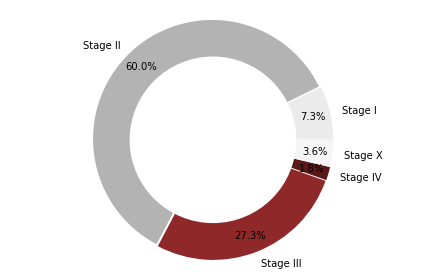

In [258]:
#Proportions of stages within cluster 0
data = data_sc_0
labels = data_sc_0.index
explode = [0.01 for record in data]
colors = ["#ebebeb", "#b3b3b3", "#8f2929", "#5c1717", "#f5f5f5"]

fig1, ax1 = plt.subplots()
ax1.pie(data_sc_0, labels = labels, explode = explode, colors = colors, pctdistance = 0.85, autopct="%1.1f%%")

centre_circle = plt.Circle((0,0), 0.7, fc ="white")
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis("equal")
plt.tight_layout()
plt.savefig(fname = "BRCA_Main_Cl0_stages.svg", format = "svg")
plt.show()

<ipython-input-259-9d20557ae747>:8: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  ax1.pie(data_sc_1, labels = labels, explode = explode, colors = colors, pctdistance = 0.85, autopct="%1.1f%%")


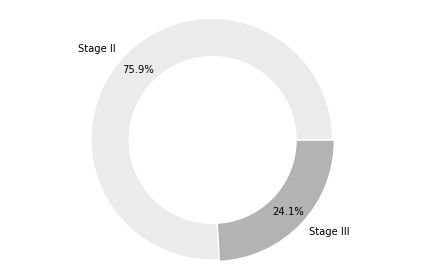

In [259]:
#Proportions of stages within cluster 1
data = data_sc_1
labels = data_sc_1.index
explode = [0.01 for record in data]
colors = ["#ebebeb", "#b3b3b3", "#8f2929", "#5c1717", "#f5f5f5"]

fig1, ax1 = plt.subplots()
ax1.pie(data_sc_1, labels = labels, explode = explode, colors = colors, pctdistance = 0.85, autopct="%1.1f%%")

centre_circle = plt.Circle((0,0), 0.7, fc ="white")
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis("equal")
plt.tight_layout()
plt.savefig(fname = "BRCA_Main_Cl1_stages.svg", format = "svg")
plt.show()


<ipython-input-260-a8c68d17c041>:8: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  ax1.pie(data_sc_2, labels = labels, explode = explode, colors = colors, pctdistance = 0.85, autopct="%1.1f%%")


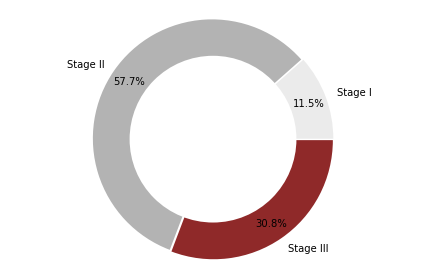

In [260]:
#Proportions of stages within cluster 2
data = data_sc_2
labels = data_sc_2.index
explode = [0.01 for record in data]
colors = ["#ebebeb", "#b3b3b3", "#8f2929", "#5c1717"]

fig1, ax1 = plt.subplots()
ax1.pie(data_sc_2, labels = labels, explode = explode, colors = colors, pctdistance = 0.85, autopct="%1.1f%%")

centre_circle = plt.Circle((0,0), 0.7, fc ="white")
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis("equal")
plt.tight_layout()
plt.savefig(fname = "BRCA_Main_Cl2_stages.svg", format = "svg")
plt.show()

In [261]:
#export a summary of the absolute counts of each stage per cluster
summary = pd.DataFrame(df_stage_cl.groupby("Cluster")["AJCC_Stage_nature2012"].value_counts())
summary.to_excel("BRCA_HER2+_Main_summary_stages.xlsx")

In [265]:
#export a table with genomic, phenotypic and cluster information 
df_pc.to_excel("BRCA_HER2+_Main.xlsx")